# 02_MoistureTransfer

## Identifying moisture transfer properties from sample weight and relative humidity measurements

This page is a tutorial on how to find the water vapour permeability and sorption isotherm of a material sample from transient measurements of its weight and internal relative humidity. The experimental setup is explained in this paper :

[Rouchier S, Busser T, Pailha M, Piot A, Woloszyn M 2017. Hygric characterization of wood fiber insulation under uncertainty with dynamic measurements and Markov Chain Monte-Carlo algorithm, Building and Environment vol. 114, p. 129-139](http://www.sciencedirect.com/science/article/pii/S0360132316305042)

The inverse problem is solved by the scipy.optimize.curve_fit function, which implements the Levenberg-Marquardt algorithm in Python.

## Prerequisites

To run this exercise, you need to download the [InverseBuilding](https://github.com/srouchier/InverseBuilding) repository and install the [hamopy](http://srouchier.github.io/hamopy/) Python package. You can then either run the `03_MoistureTransfer.py` script or copy the following code snippets.

## Description of the exercise

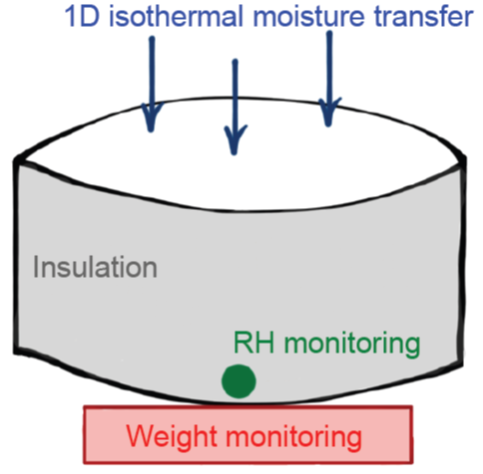

In [1]:
%matplotlib inline
from IPython.display import Image
Image(filename='figures/exp_setup.png', width = 240)

A cylindrical porous sample is placed on a scale within a chamber of controlled relative humidity. The mass uptake and the weight gain of the sample are continously recorded after a stepwise change in ambient relative humidity. The target of the problem is to use these measurements to find the water vapour permeability and sorption isotherm of this material.

## Reading data

The measurements used as input and output of the model are given in the `measurements.txt` file.

In [2]:
import numpy as np
from copy import deepcopy

# Loading the data file
import pandas
data_file = pandas.read_csv('measurements.txt', delimiter = '\t')

# Reading columns of the data file into numpy arrays
data_RH = np.array(data_file['RH1'])        # relative humidity at the bottom of the sample
data_W  = np.array(data_file['Mass (g)'])    # sample weight
data_W -= data_W[0] # start the weight at zero

# Measurement uncertainty on each output
std_noise_H = 0.01
std_noise_M  = 0.1
# Each output series is divided by its uncertainty, as to give each of them an equal weight
data_RH /= std_noise_H
data_W /= std_noise_M

# Summing up the data we will need later
data_t = np.array(data_file['Time (s)'])    # time steps of the measurements
data_y = np.concatenate((data_RH, data_W))  # output to be fitted on

data_x = np.arange(len(data_y))             # dummy variable, required as input anyway

# Sample size
h = 0.08    # height
D = 0.111   # diameter

## Cost function

We then define a cost function, which will simulate the experiment using a set of parameters. There are six parameters to estimate simultaneously from this experiment: the surface transfer coefficient `h_m`, the permeability `dp_1` and `dp_2`, and the sorption isotherm `xi_1`, `xi_2` and `xi_3`. The simulation uses the [hamopy](http://srouchier.github.io/hamopy/) Python package to simulate coupled heat and moisture transfer in porous materials.

In [ ]:
from hamopy.algorithm import calcul
from hamopy.postpro import evolution, distribution
import hamopy.ham_library as ham

from hamopy_inputs import mesh, clim, init, time

def func(x, h_m, dp_1, dp_2, xi_1, xi_2, xi_3):
    
    # Boundary condition
    clim[0].data['h_m'] = h_m
    # Material properties    
    m = deepcopy(mesh.materials[0])
    m.set_perm_vapor('interp', **{"HR" : [0.25, 0.75],
                                  "dp" : [dp_1, dp_2] } )                       
    m.set_isotherm('slope', **{"HR" : [0.25, 0.5, 0.75],
                               "XI" : [xi_1, xi_2, xi_3]  } )
    mesh.replace_materials([m])
    
    # Simulation
    res = calcul(mesh, clim, init, time)
    
    if res['t'].max() < data_t.max():
        # If the simulation has been interrupted before the end, return zeros
        print('One of the simulations has failed \n')
        return np.zeros_like(data_y)
        #return np.zeros(len(t_mesure))
        
    else:
        # Output 1: relative humidityat the bottom of the sample
        H = evolution(res, 'HR', h, data_t) / std_noise_H
        
        # Output 2: weight gain of the sample
        # The total weight gain is the integral of the moisture content over the sample volume
        x_integ = np.linspace(0, h)
        W = np.zeros_like(data_t)
        for i in range(len(data_t)):
            hum = distribution(res, 'HR', x_integ, data_t[i])
            tem = distribution(res, 'T', x_integ, data_t[i])
            w_integ = m.w(ham.p_c(hum,tem), tem)
            W[i] = np.trapz(y = w_integ, x = x_integ)
        M = W * np.pi*D**2/4*1000 # pour passer de (kg/m2) a des (g)
        M -= M[0]
        M /= std_noise_M

        return np.concatenate((H, M))

## Curve fitting

Now we just have to start the algorithm for curve fitting. It is the `curve_fit` method of the `scipy.optimize` package, and pretty simple to operate. It returns the least square estimator as `popt` and its covariance matrix as `pcov`.

These few lines may take a few minutes to run, depending on whether the initial guess is accurate or not.

In [ ]:
# Initial guess
p_init =  [6.0e-9, 3e-10, 2e-10, 20, 15, 10]
# Fitting
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, data_x, data_y, p0 = p_init)

## Plotting results

In order to visualise how well the model fits the data, let us run one last simulation with the optimal parameters as input, and plot its results versus measurement data.

In [ ]:
opt_calc = func(data_x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])

opt_H = opt_calc[:len(data_t)]
opt_W = opt_calc[len(data_t):]

import matplotlib.pyplot as plt

plt.figure()
plt.plot(data_t/3600, data_RH * std_noise_H, '-k', label = 'Measurements')
plt.plot(data_t/3600, opt_H * std_noise_H, '-r', label = 'Simulation')
plt.xlabel('Time (h)')
plt.ylabel('Relative humidity')
plt.legend(loc='lower right')

plt.figure()
plt.plot(data_t/3600, data_W * std_noise_M, '-k', label = 'Measurements')
plt.plot(data_t/3600, opt_W * std_noise_M, 'r', label = 'Simulation')
plt.xlabel('Time (h)')
plt.ylabel('Water content (kg/m3)')
plt.legend(loc='lower right')

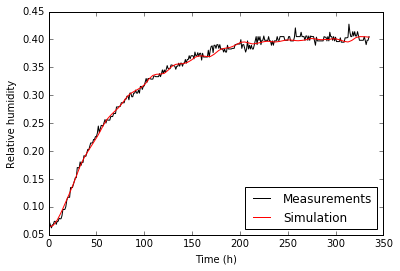

In [4]:
Image(filename='figures/fit_RH.png', width = 240)

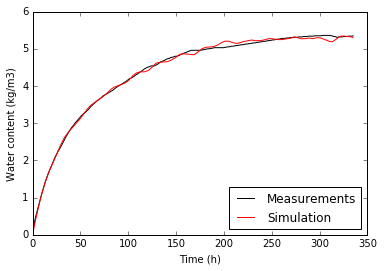

In [3]:
Image(filename='figures/fit_W.png', width = 240)